In [ ]:
import re
import os, glob
import numpy as np
from PIL import Image
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.client import device_lib

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"{len(gpus)}개의 GPU가 감지되었습니다.")
    except RuntimeError as e:
        print(e)
else:
    print("GPU를 찾을 수 없습니다. CPU를 사용합니다.")
print(device_lib.list_local_devices())

1개의 GPU가 감지되었습니다.
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4989418168663359869
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10063183872
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8548789973108155493
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [ ]:
# 이미지 불러오기

def extract_date_key(path):
    # 파일명에서 6자리 연월 추출: img_197811.png → 197811 (정수형)
    match = re.search(r'(\d{6})', os.path.basename(path))
    return int(match.group(1)) if match else -1

def load_images_from_folder(folder, target_size=(256, 256)):
    paths = sorted(glob.glob(os.path.join(folder, '*.png')), key=extract_date_key)
    images = []
    for path in paths:
        img = Image.open(path).convert('L').resize(target_size)
        img_array = np.array(img) / 127.5 - 1.0  # [-1, 1] 정규화
        images.append(img_array[..., np.newaxis])  # (256,256,1)
    return np.array(images)

image_folder = "./img256"
images = load_images_from_folder(image_folder)
print("Loaded image shape:", images.shape)  # (N, 256, 256, 1)

Loaded image shape: (558, 256, 256, 1)


In [ ]:
# Autoencoder 인코더 정의

encoding_dim = 512

def build_encoder(input_shape=(256, 256, 1), latent_dim=512):
    inputs = layers.Input(shape=input_shape)

    x1 = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x1p = layers.MaxPooling2D(2)(x1)  # 128x128

    x2 = layers.Conv2D(64, 3, activation='relu', padding='same')(x1p)
    x2p = layers.MaxPooling2D(2)(x2)  # 64x64

    x3 = layers.Conv2D(128, 3, activation='relu', padding='same')(x2p)
    x3p = layers.MaxPooling2D(2)(x3)  # 32x32

    x4 = layers.Conv2D(256, 3, activation='relu', padding='same')(x3p)
    x4p = layers.MaxPooling2D(2)(x4)  # 16x16

    x = layers.Flatten()(x4p)
    latent = layers.Dense(latent_dim)(x)

    return models.Model(inputs, [latent, x1, x2, x3], name='Encoder')

# U-Net 구조 디코더더
def build_decoder(latent_dim=512):
    z = tf.keras.Input(shape=(latent_dim,))
    skip3 = tf.keras.Input(shape=(64, 64, 128))   # x3
    skip2 = tf.keras.Input(shape=(128, 128, 64))  # x2
    skip1 = tf.keras.Input(shape=(256, 256, 32))  # x1

    x = layers.Dense(8 * 8 * 256, activation='relu')(z)
    x = layers.Reshape((8, 8, 256))(x)

    x = layers.Conv2DTranspose(256, 3, strides=2, padding='same', activation='relu')(x)  # 16x16
    x = layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(x)  # 32x32
    x = layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(x)  # 64x64
    x = layers.Concatenate()([x, skip3])  # 64x64

    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)   # 128x128
    x = layers.Concatenate()([x, skip2])

    x = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(x)   # 256x256
    x = layers.Concatenate()([x, skip1])

    outputs = layers.Conv2D(1, 3, activation='tanh', padding='same')(x)
    return tf.keras.Model([z, skip3, skip2, skip1], outputs)

encoder = build_encoder()
decoder = build_decoder()

print(encoder.summary())

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 128)       7385

In [ ]:
# 모델 연결
ae_input = tf.keras.Input(shape=(256, 256, 1))
latent, x1, x2, x3 = encoder(ae_input)
recon = decoder([latent, x3, x2, x1])  # 순서 반드시 일치

autoencoder = tf.keras.Model(ae_input, recon)

# 컴파일 
autoencoder.compile(optimizer='adam', loss='mse')

In [50]:
early_stop = EarlyStopping(
    monitor='val_loss',  # 검증 손실을 기준
    patience=10,         # 10번 연속 개선되지 않으면
    min_delta=1e-5,
    restore_best_weights=True
)

checkpoint_ae = ModelCheckpoint(
    filepath='best_weights.h5',       # 저장 파일명
    monitor='val_loss',               # 어떤 값을 기준으로 저장할지
    save_best_only=True,              # 가장 좋은 값일 때만 저장
    save_weights_only=True,           # 전체 모델이 아니라 가중치만 저장
    verbose=1                         # 저장될 때마다 메시지 출력
)

# 학습
history = autoencoder.fit(
    images, images, 
    epochs=100, 
    batch_size=2, 
    validation_split=0.2, 
    callbacks=[early_stop, checkpoint_ae]
)

autoencoder.load_weights('best_weights.h5')

Epoch 1/100
223/223 [==============================] - ETA: 0s - loss: 0.0159
Epoch 1: val_loss improved from inf to 0.00178, saving model to best_weights.h5
223/223 [==============================] - 10s 40ms/step - loss: 0.0159 - val_loss: 0.0018
Epoch 2/100
222/223 [============================>.] - ETA: 0s - loss: 0.0013
Epoch 2: val_loss improved from 0.00178 to 0.00090, saving model to best_weights.h5
223/223 [==============================] - 9s 41ms/step - loss: 0.0013 - val_loss: 8.9700e-04
Epoch 3/100
223/223 [==============================] - ETA: 0s - loss: 7.5111e-04
Epoch 3: val_loss improved from 0.00090 to 0.00057, saving model to best_weights.h5
223/223 [==============================] - 9s 40ms/step - loss: 7.5111e-04 - val_loss: 5.6683e-04
Epoch 4/100
223/223 [==============================] - ETA: 0s - loss: 4.9766e-04
Epoch 4: val_loss improved from 0.00057 to 0.00041, saving model to best_weights.h5
223/223 [==============================] - 9s 41ms/step - loss: 4

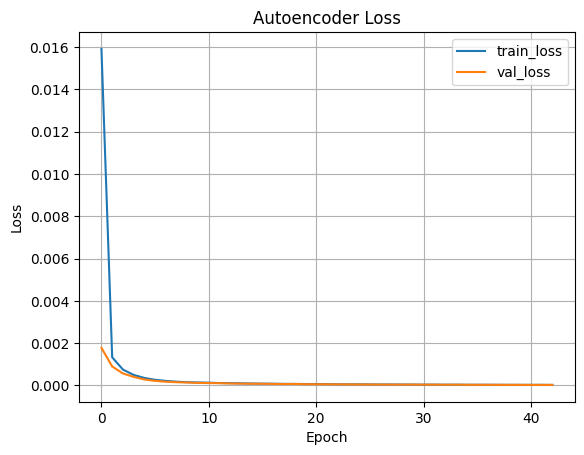

In [51]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Autoencoder Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


1/1 [==============================] - 0s 172ms/step


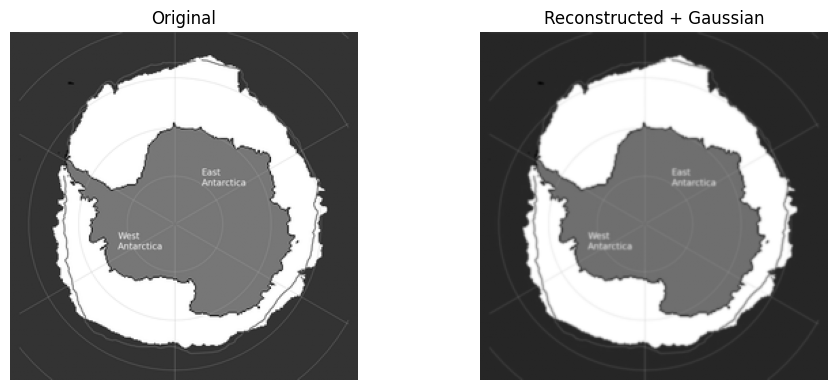

In [ ]:
### Autoencoder 복원 이미지 시각화

from scipy.ndimage import gaussian_filter

test_img = images[0:1]  # shape: (1, 256, 256, 1)

# Autoencoder 복원
recon_img = autoencoder.predict(test_img)

# 후처리 (Gaussian Filter 적용)
recon_img_filtered = gaussian_filter(recon_img[0].squeeze(), sigma=0.6)

# 시각화할 때는 [0, 1] 범위로 다시 변환
original_display = (test_img[0].squeeze() + 1) / 2
reconstructed_display = (recon_img_filtered + 1) / 2

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(original_display, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Reconstructed + Gaussian")
plt.imshow(reconstructed_display, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# 시퀀스 데이터 생성
seq_len = 60 #5년치 데이터
X, y = [], []
for i in range(len(images) - seq_len):
    X.append(images[i:i+seq_len])  # (12, 256, 256, 1)
    y.append(images[i+seq_len])    # (256, 256, 1)
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)
print("X shape:", X.shape, "y shape:", y.shape)

X shape: (498, 60, 256, 256, 1) y shape: (498, 256, 256, 1)


In [58]:
# === 2. Train / Val / Test 분할 (shuffle=False) ===
total = len(X)
train_end = int(total * 0.6)
val_end = int(total * 0.8)

X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]

In [59]:
# 이미지 ➝ latent 변환
def encode_latents(X_seq, y_img):
    latent_seq = np.array([
        [encoder(img[np.newaxis, ...])[0].numpy().squeeze() for img in seq]
        for seq in X_seq
    ])
    latent_target = np.array([
        encoder(target[np.newaxis, ...])[0].numpy().squeeze() for target in y_img
    ])
    return latent_seq, latent_target

latent_seqs_train, latent_targets_train = encode_latents(X_train, y_train)
latent_seqs_val, latent_targets_val = encode_latents(X_val, y_val)
latent_seqs_test, latent_targets_test = encode_latents(X_test, y_test)

In [60]:
# 정규화 (train 기준으로 fit)
scaler = StandardScaler()
latent_seqs_train_scaled = scaler.fit_transform(latent_seqs_train.reshape(-1, encoding_dim)).reshape(latent_seqs_train.shape)
latent_targets_train_scaled = scaler.transform(latent_targets_train)

latent_seqs_val_scaled = scaler.transform(latent_seqs_val.reshape(-1, encoding_dim)).reshape(latent_seqs_val.shape)
latent_targets_val_scaled = scaler.transform(latent_targets_val)

latent_seqs_test_scaled = scaler.transform(latent_seqs_test.reshape(-1, encoding_dim)).reshape(latent_seqs_test.shape)
latent_targets_test_scaled = scaler.transform(latent_targets_test)


In [ ]:
# GRU 기반 시계열 예측기 모델 정의
def build_gru_predictor(seq_len, latent_dim):
    model = models.Sequential([
        layers.GRU(256, input_shape=(seq_len, latent_dim)),
        layers.Dropout(0.2),
        layers.Dense(latent_dim)
    ])
    return model

predictor = build_gru_predictor(seq_len=60, latent_dim=encoding_dim)
predictor.compile(optimizer='adam', loss='mse')
print(predictor.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 256)               591360    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 512)               131584    
                                                                 
Total params: 722,944
Trainable params: 722,944
Non-trainable params: 0
_________________________________________________________________
None


In [62]:
# 모델 학습 

checkpoint_gr = ModelCheckpoint(
    filepath='best_weights2.h5',       # 저장 파일명
    monitor='val_loss',               # 어떤 값을 기준으로 저장할지
    save_best_only=True,              # 가장 좋은 값일 때만 저장
    save_weights_only=True,           # 전체 모델이 아니라 가중치만 저장
    verbose=1                         # 저장될 때마다 메시지 출력
)

history = predictor.fit(
    latent_seqs_train_scaled, latent_targets_train_scaled,
    validation_data=(latent_seqs_val_scaled, latent_targets_val_scaled),
    epochs=100, batch_size=2, 
    callbacks=[early_stop, checkpoint_gr]
)

predictor.load_weights('best_weights2.h5')

Epoch 1/100
142/149 [===========================>..] - ETA: 0s - loss: 0.3130
Epoch 1: val_loss improved from inf to 0.10885, saving model to best_weights2.h5
149/149 [==============================] - 3s 11ms/step - loss: 0.3064 - val_loss: 0.1088
Epoch 2/100
147/149 [============================>.] - ETA: 0s - loss: 0.1486
Epoch 2: val_loss did not improve from 0.10885
149/149 [==============================] - 1s 8ms/step - loss: 0.1481 - val_loss: 0.1120
Epoch 3/100
142/149 [===========================>..] - ETA: 0s - loss: 0.1262
Epoch 3: val_loss improved from 0.10885 to 0.10564, saving model to best_weights2.h5
149/149 [==============================] - 1s 8ms/step - loss: 0.1274 - val_loss: 0.1056
Epoch 4/100
146/149 [============================>.] - ETA: 0s - loss: 0.1141
Epoch 4: val_loss improved from 0.10564 to 0.08517, saving model to best_weights2.h5
149/149 [==============================] - 1s 8ms/step - loss: 0.1144 - val_loss: 0.0852
Epoch 5/100
144/149 [============

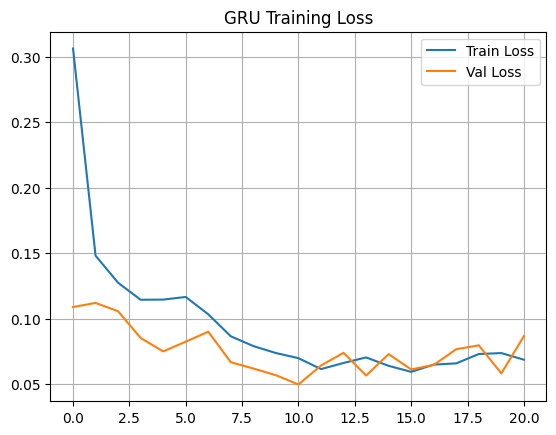

In [63]:
# 시각화
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("GRU Training Loss")
plt.grid(True)
plt.show()

GT mean: -0.3831253 Input mean: -0.2545283


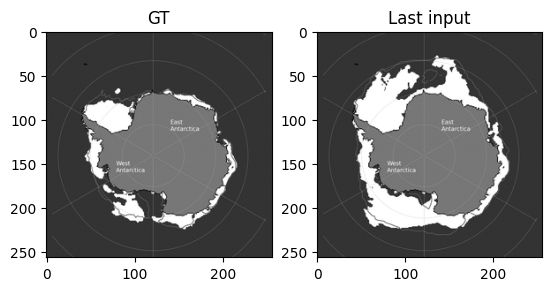

In [64]:
idx = 0

# skip 추출용으로 사용한 입력 이미지
last_input_img = X_test[idx][-1]

# 실제 정답 이미지
gt_img = y_test[idx]

# 두 이미지가 진짜 같은지 비교
print("GT mean:", np.mean(gt_img), "Input mean:", np.mean(last_input_img))

plt.subplot(1, 2, 1)
plt.title("GT")
plt.imshow(gt_img.squeeze(), cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Last input")
plt.imshow(last_input_img.squeeze(), cmap='gray')
plt.show()

In [65]:
# idx = 0 기준
latent_input = latent_seqs_test_scaled[idx][-1]
latent_pred = predictor.predict(latent_seqs_test_scaled[idx:idx+1])[0]
latent_target = latent_targets_test_scaled[idx]

print("input vs pred:", np.mean(np.abs(latent_input - latent_pred)))
print("target vs pred:", np.mean(np.abs(latent_target - latent_pred)))


1/1 [==============================] - 0s 269ms/step
input vs pred: 0.7246782
target vs pred: 0.28282773


1/1 [==============================] - 0s 219ms/step


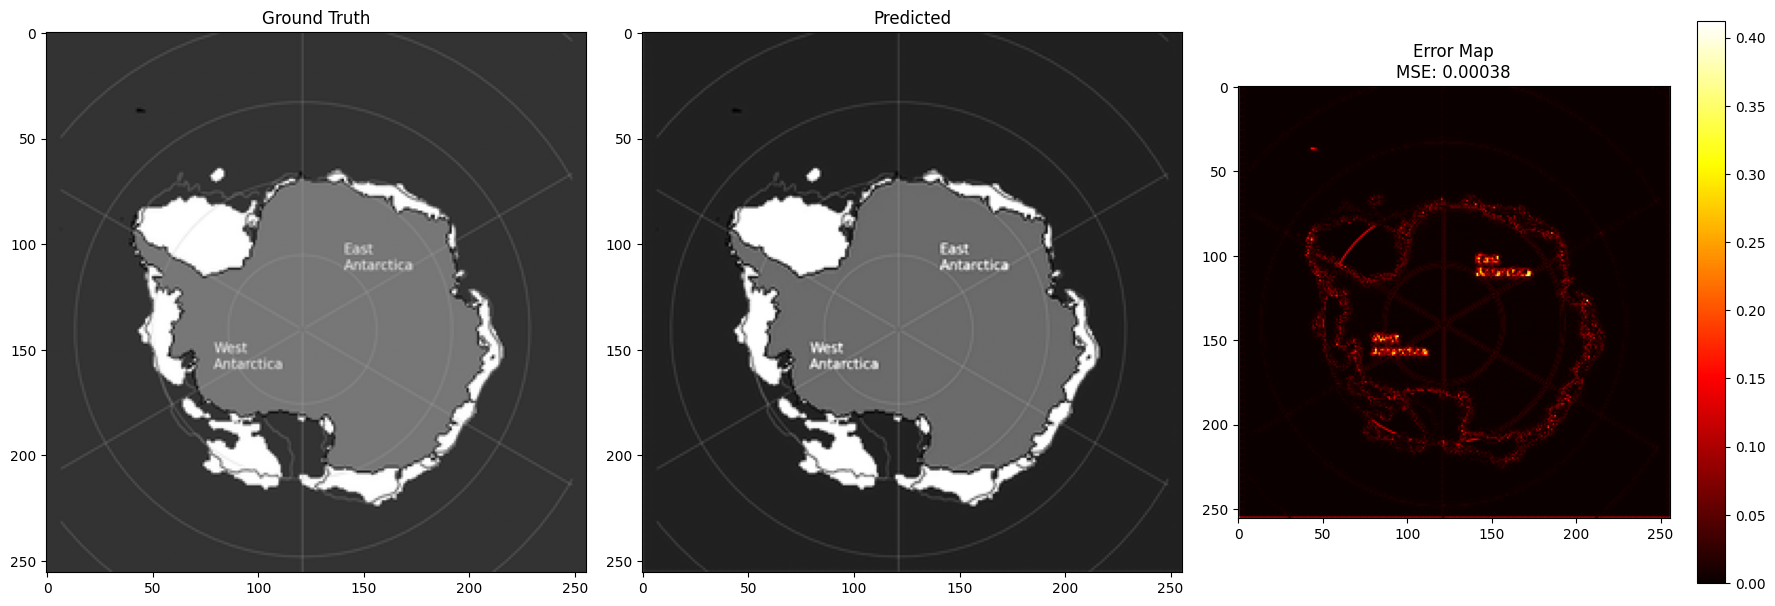

In [ ]:
### GRU 예측 latent 벡터를 디코더로 복원하여 이미지 예측 수행

# 예측 인덱스 선택 
idx = 0

# GRU로 latent 예측 
pred_latent_scaled = predictor.predict(latent_seqs_test_scaled[idx:idx+1])  # (1, latent_dim)

# 해당 시퀀스의 마지막 이미지로부터 skip 추출 
target_input = X_test[idx][-1]  # 마지막 프레임 (256x256x1)
_, s1, s2, s3 = encoder(y_test[idx][np.newaxis, ...])  # (1, H, W, C) 유지

# decoder로 skip 포함 이미지 복원 
pred_image = decoder.predict([pred_latent_scaled, s3, s2, s1])  # ← decoder 입력 순서에 맞춤

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.title("Ground Truth")
plt.imshow(y_test[idx].squeeze(), cmap='gray')

plt.subplot(1, 3, 2)
plt.title("Predicted")
plt.imshow(pred_image[0].squeeze(), cmap='gray')

plt.subplot(1, 3, 3)
error = np.abs(y_test[idx].squeeze() - pred_image[0].squeeze())
mse = np.mean(error**2)
plt.title(f"Error Map\nMSE: {mse:.5f}")
plt.imshow(error, cmap='hot')
plt.colorbar()

plt.tight_layout()
plt.show()

In [67]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def evaluate_predictions(X_test, y_test, latent_seqs_test_scaled, latent_targets_test_scaled, predictor, decoder, encoder, max_samples=20):
    mse_list, ssim_list, psnr_list = [], [], []

    for idx in range(min(max_samples, len(X_test))):
        # latent 예측
        pred_latent = predictor.predict(latent_seqs_test_scaled[idx:idx+1])

        # skip 연결: Ground Truth 기준으로 추출
        _, s1, s2, s3 = encoder(y_test[idx][np.newaxis, ...])

        # 복원
        pred_img = decoder.predict([pred_latent, s3, s2, s1])[0].squeeze()
        gt_img = y_test[idx].squeeze()

        # 지표 계산
        mse_val = np.mean((gt_img - pred_img)**2)
        ssim_val = ssim(gt_img, pred_img, data_range=2.0)  # [-1, 1] 정규화 기준
        psnr_val = psnr(gt_img, pred_img, data_range=2.0)

        mse_list.append(mse_val)
        ssim_list.append(ssim_val)
        psnr_list.append(psnr_val)

    return mse_list, ssim_list, psnr_list


In [ ]:
mse_list, ssim_list, psnr_list = evaluate_predictions(
    X_test, y_test, 
    latent_seqs_test_scaled, latent_targets_test_scaled,
    predictor, decoder, encoder,
    max_samples=30
)

print(f"✅ 평균 MSE:  {np.mean(mse_list):.6f}")
print(f"✅ 평균 SSIM: {np.mean(ssim_list):.4f}")
print(f"✅ 평균 PSNR: {np.mean(psnr_list):.2f} dB")


1/1 [==============================] - 0s 21ms/step
✅ 평균 MSE:  0.000414
✅ 평균 SSIM: 0.9845
✅ 평균 PSNR: 39.87 dB


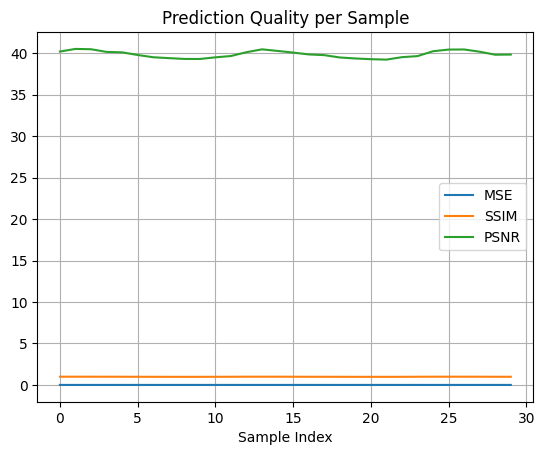

In [70]:
plt.plot(mse_list, label='MSE')
plt.plot(ssim_list, label='SSIM')
plt.plot(psnr_list, label='PSNR')
plt.title('Prediction Quality per Sample')
plt.xlabel('Sample Index')
plt.legend()
plt.grid(True)
plt.show()


In [72]:
# MSE 기준 상/하위 index 계산
worst_indices = np.argsort(mse_list)[-3:][::-1]  # MSE 높은 순
best_indices = np.argsort(mse_list)[:3]          # MSE 낮은 순


📉 Top-3 Worst Samples
--- idx 21 ---
1/1 [==============================] - 0s 25ms/step


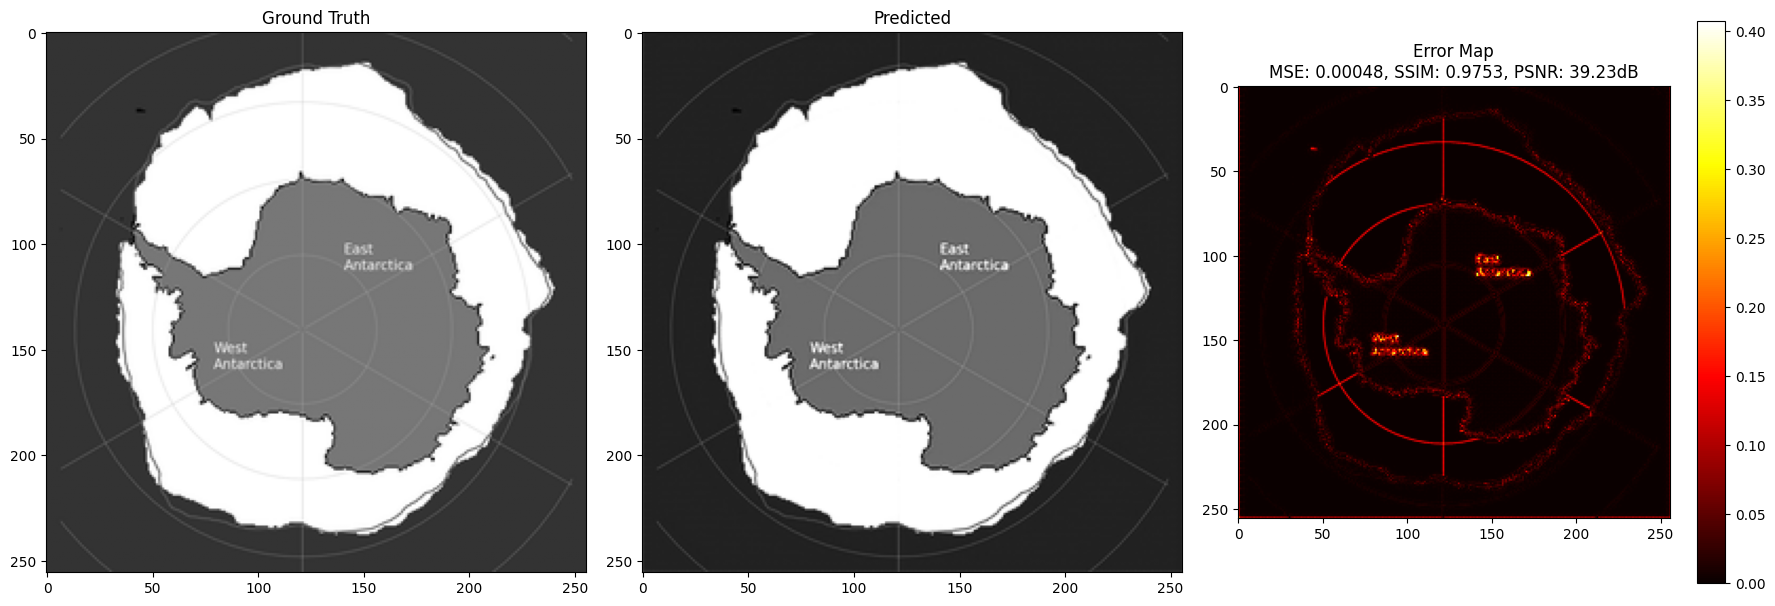

MSE: 0.000477, SSIM: 0.9753, PSNR: 39.23 dB

--- idx 20 ---
1/1 [==============================] - 0s 23ms/step


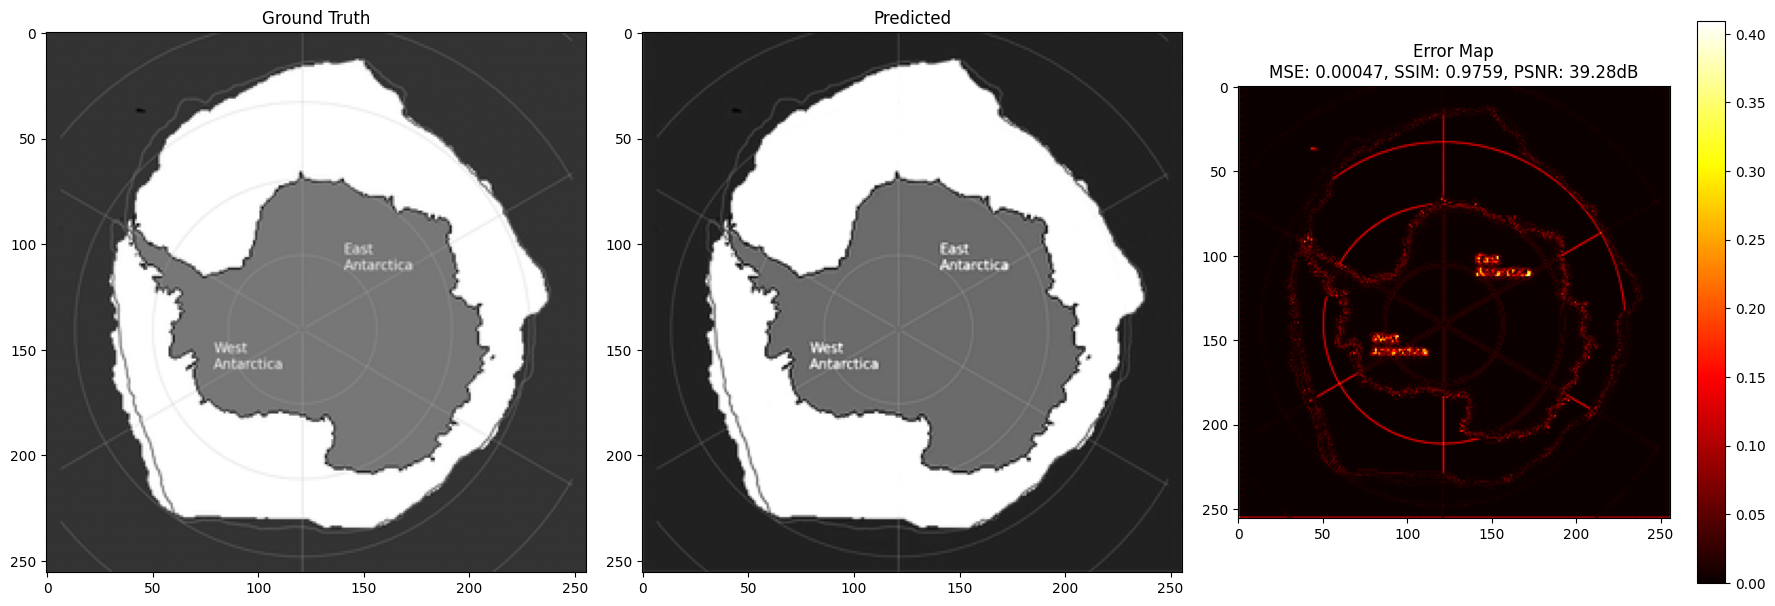

MSE: 0.000472, SSIM: 0.9759, PSNR: 39.28 dB

--- idx 9 ---
1/1 [==============================] - 0s 24ms/step


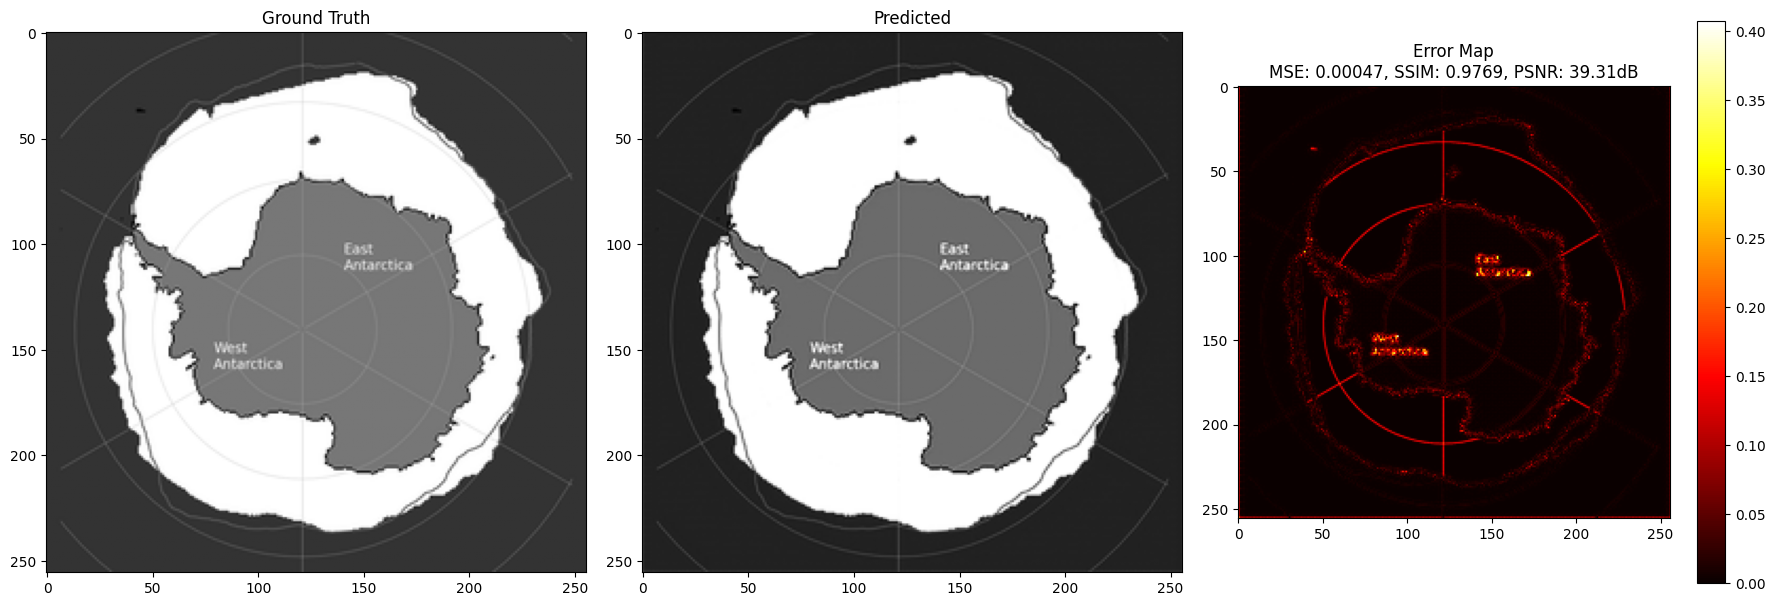

MSE: 0.000469, SSIM: 0.9769, PSNR: 39.31 dB



In [73]:
print("📉 Top-3 Worst Samples")

for i in worst_indices:
    print(f"--- idx {i} ---")
    mse, ssim_val, psnr_val = visualize_prediction(
        i, 
        X_test, 
        y_test, 
        latent_seqs_test_scaled, 
        predictor, 
        decoder, 
        encoder
    )
    print(f"MSE: {mse:.6f}, SSIM: {ssim_val:.4f}, PSNR: {psnr_val:.2f} dB\n")


🥇 Top-3 Best Samples
--- idx 1 ---
1/1 [==============================] - 0s 23ms/step


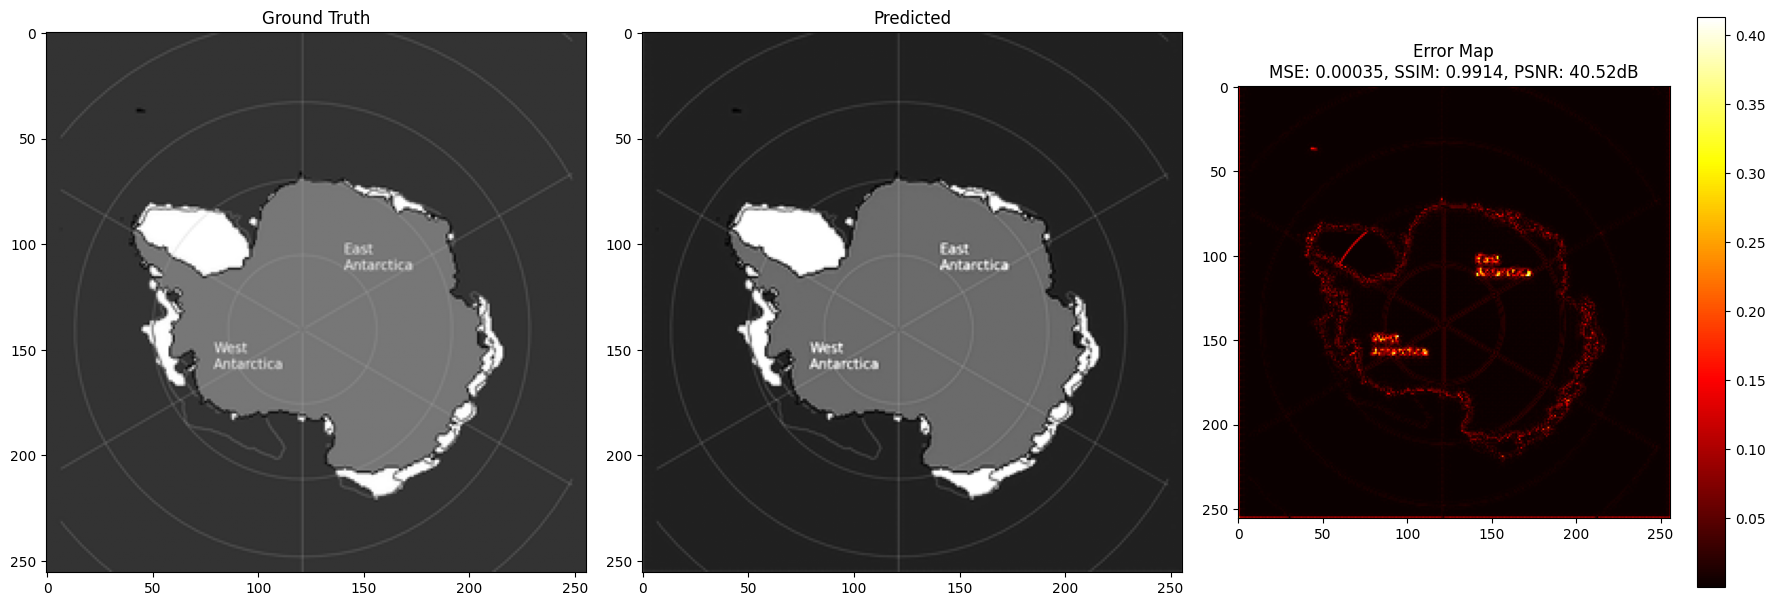

MSE: 0.000355, SSIM: 0.9914, PSNR: 40.52 dB

--- idx 2 ---
1/1 [==============================] - 0s 23ms/step


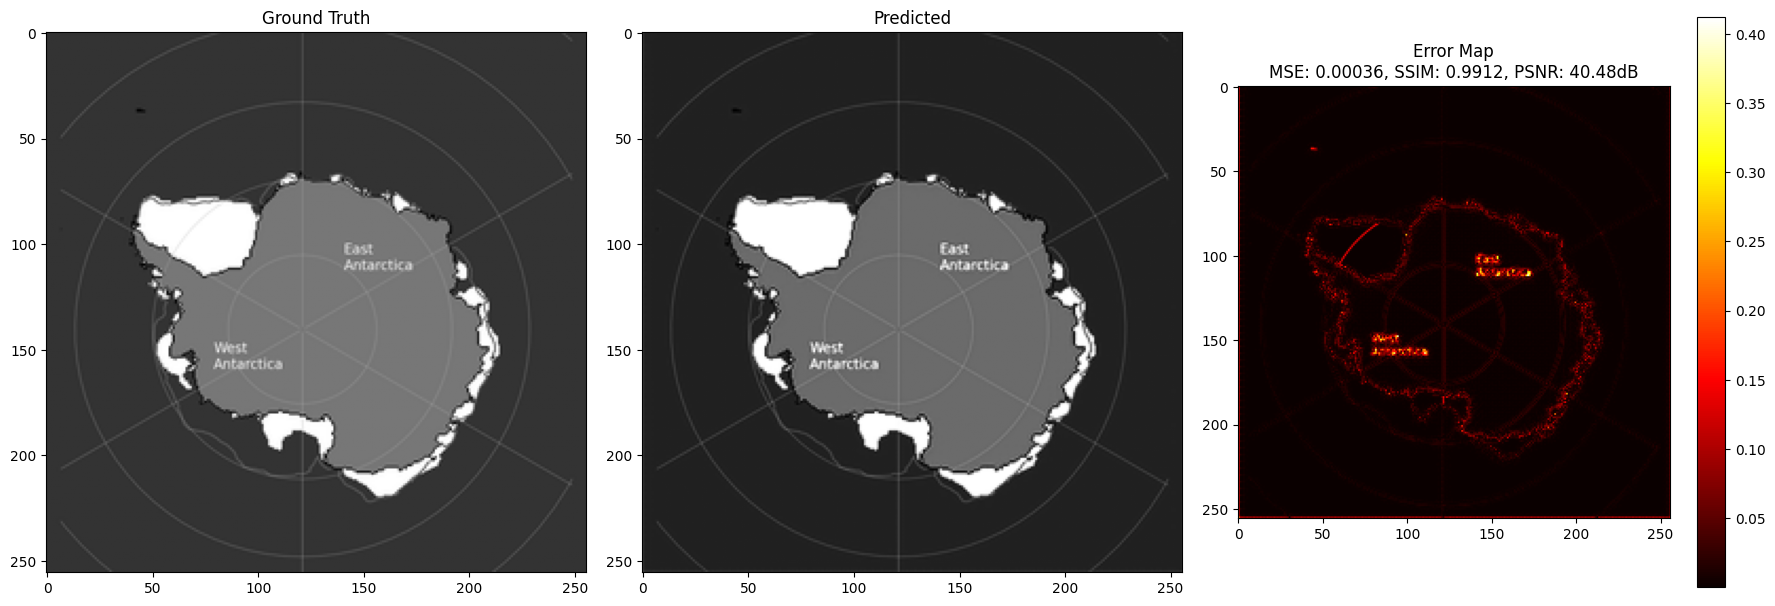

MSE: 0.000358, SSIM: 0.9912, PSNR: 40.48 dB

--- idx 13 ---
1/1 [==============================] - 0s 22ms/step


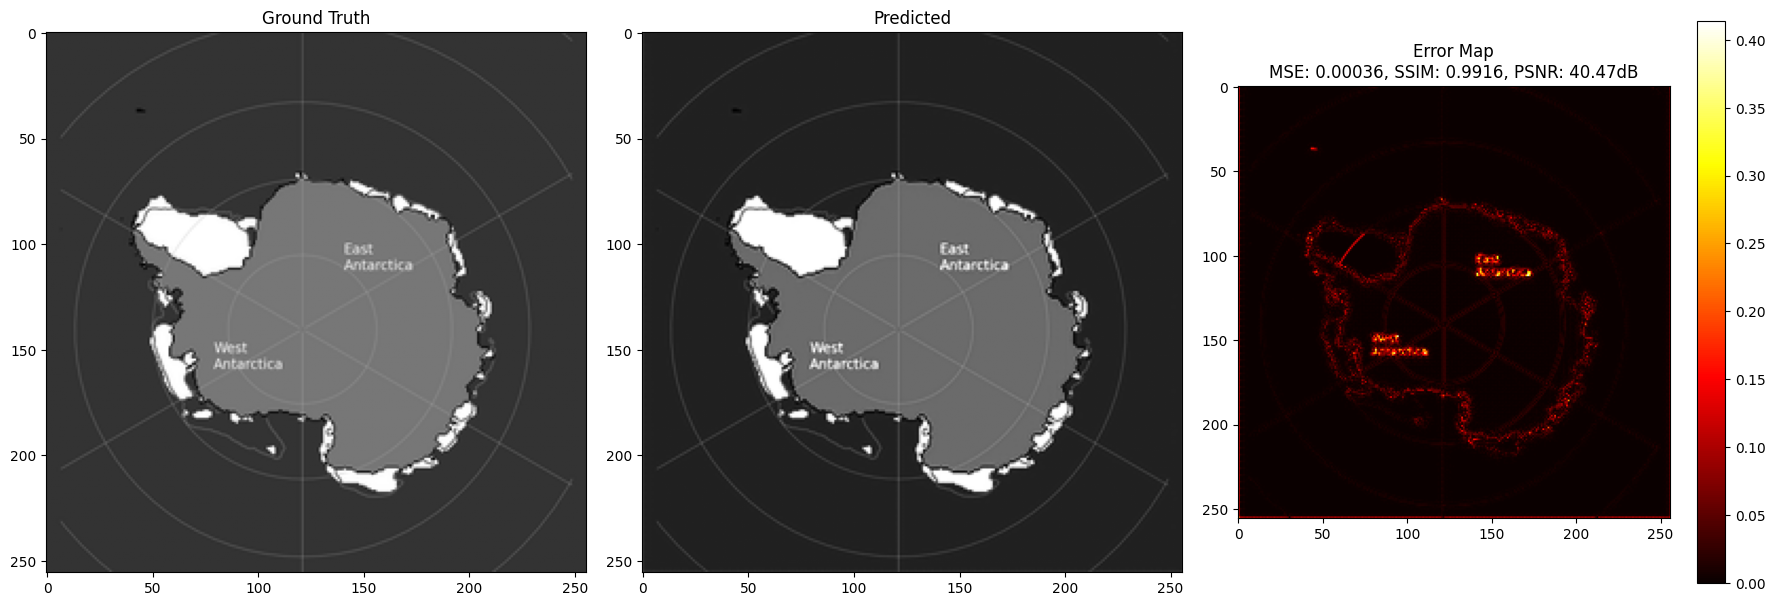

MSE: 0.000359, SSIM: 0.9916, PSNR: 40.47 dB



In [74]:
print("🥇 Top-3 Best Samples")
for i in best_indices:
    print(f"--- idx {i} ---")
    mse, ssim_val, psnr_val = visualize_prediction(
        i, 
        X_test, 
        y_test, 
        latent_seqs_test_scaled, 
        predictor, 
        decoder, 
        encoder
    )
    print(f"MSE: {mse:.6f}, SSIM: {ssim_val:.4f}, PSNR: {psnr_val:.2f} dB\n")
